# Imports and Data

In [1]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)


# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

In [ ]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

In [ ]:
DF_MESSAGES.head()

# Time window

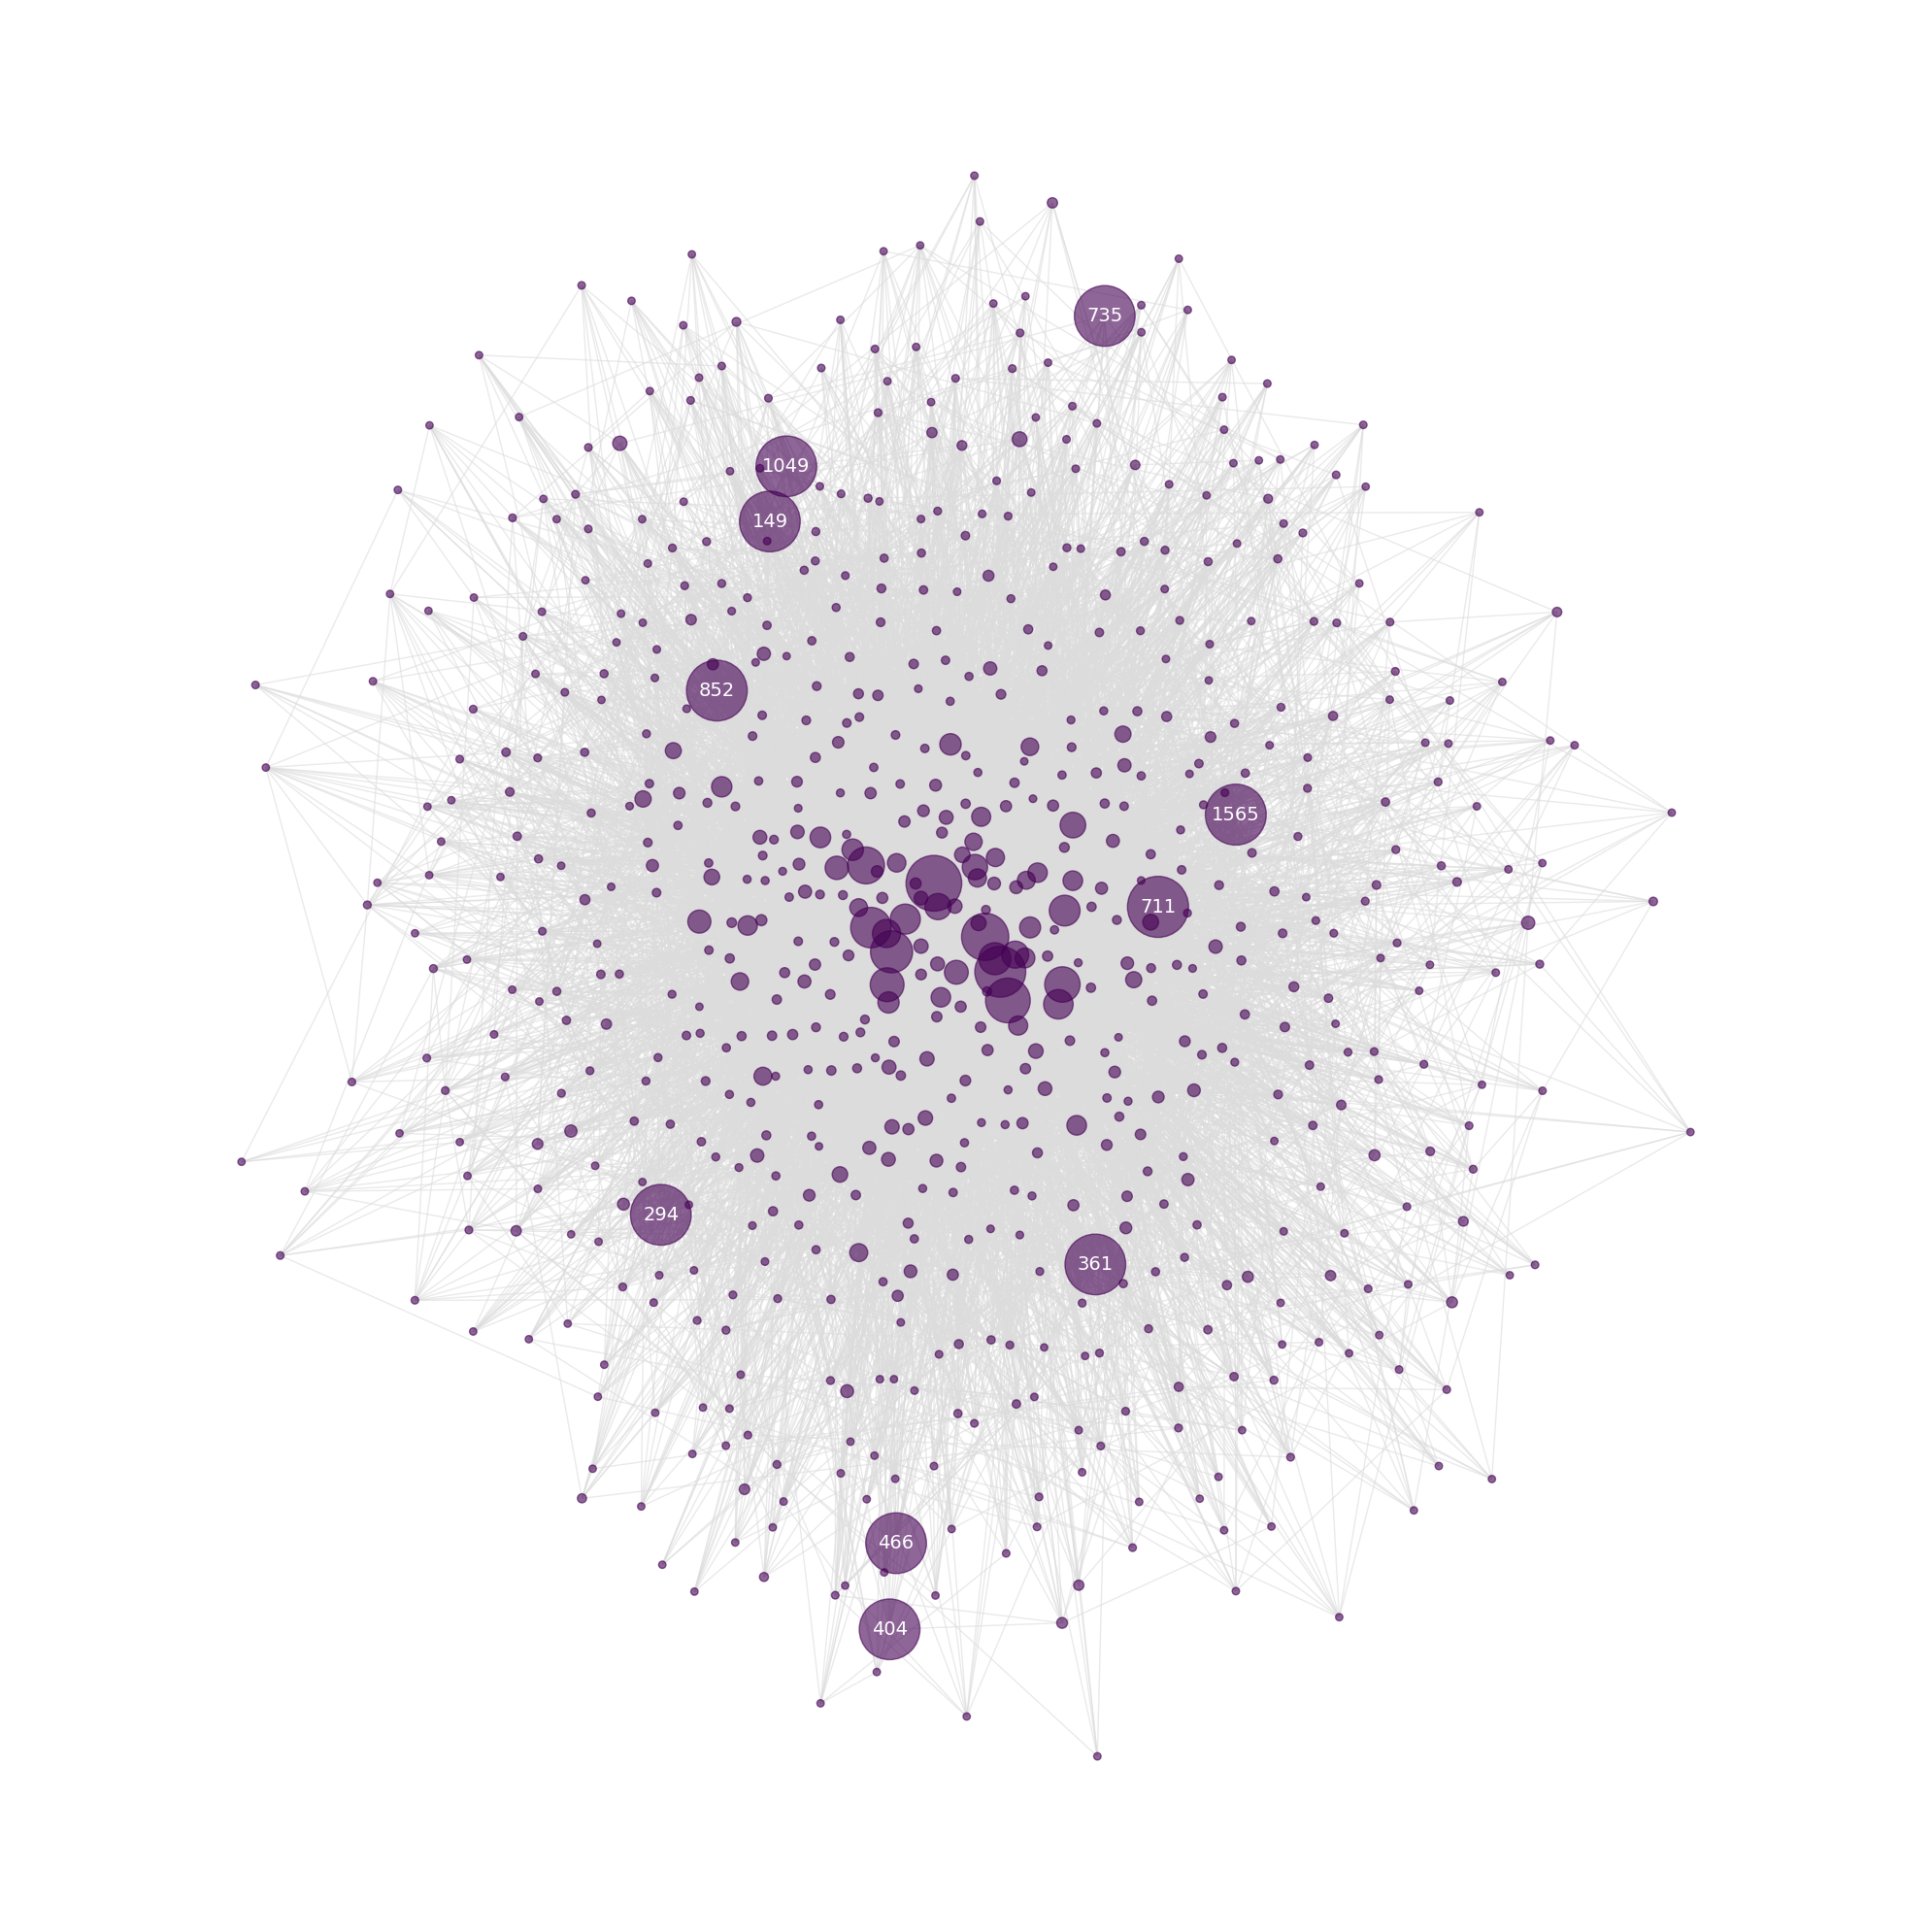

In [11]:
from random import sample
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(GRAPH_MESSAGES)

# remove low-degree nodes
low_degree = [n for n, d in G.degree() if d < 10]
G.remove_nodes_from(low_degree)

# largest connected component
components = nx.connected_components(G)
largest_component = max(components, key=len)
H = G.subgraph(largest_component)

# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 20))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.6,
)


# Find top 10 nodes by betweenness centrality
top_10_nodes = sorted(centrality, key=centrality.get, reverse=True)[:10]

# Add labels for top 10 nodes
nx.draw_networkx_labels(H, pos, labels={n: n for n in top_10_nodes}, font_size=14, font_color="white")


# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.savefig("betweenness.png")
plt.show()